Gate cutting to reduce circuit width


Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


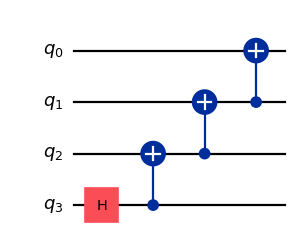

In [3]:
import numpy as np
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2
from qiskit_addon_cutting import (
    cut_gates,
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)
from component.b_benchmark.mqt_tool import benchmark_circuit

qc = benchmark_circuit("ghz", 4)
qc.remove_final_measurements()
 
observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")
 
qc.draw("mpl", scale=0.8)

Sampling overhead: 9.0
Subobservables: {'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']), 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}


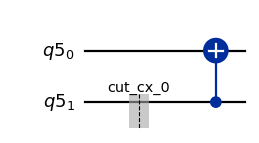

In [6]:
from qiskit_addon_cutting import partition_problem

create_string = "AABB"
partitioned_problem = partition_problem(
    circuit=qc, partition_labels=create_string, observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
print(f"Subobservables: {subobservables}")
subcircuits["A"].draw("mpl", scale=0.8)

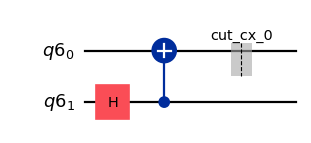

In [7]:
subcircuits["B"].draw("mpl", scale=0.8)

In [ ]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
 
# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}
 
# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=4096 * 3)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
 
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

In [ ]:
# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
 
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
 
 
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(qc, observable, [0.4] * len(qc.parameters))])
    .result()[0]
    .data.evs
)
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)